In [440]:
import numpy as np
import pandas as pdcoding
import gzip

In [441]:
#SOMToolbox Parser
from SOMToolBox_Parse import SOMToolBox_Parse
idata = SOMToolBox_Parse("datasets\\chainlink\\chainlink.vec").read_weight_file()
weights = SOMToolBox_Parse("datasets\\chainlink\\chainlink.wgt.gz").read_weight_file()
label_names = SOMToolBox_Parse("datasets\\chainlink\\chainlink.tv").read_template_vec_file()


In [442]:
#HitHistogram
def HitHist(_m, _n, _weights, _idata):
    hist = np.zeros(_m * _n)
    for vector in _idata:
        position = np.argmin(np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1)))
        hist[position] += 1

    return hist.reshape(_m, _n)

In [443]:
#fills a library with every input vector mapped to their closest unit
def vectorsPerUnit(_weights, _idata):
    vectors_per_unit = {}
    for vector in _idata:
        position = np.argmin(np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1)))
        if position not in vectors_per_unit:
            vectors_per_unit[position] = []
        vectors_per_unit[position].append(vector)
    return vectors_per_unit

In [ ]:
#to test that our gathering of vectors is correct we can compare it to the very similar HitHistogram visualization.
#if the vectorsPerUnit can generate the exact same histogram as HitHist, we know that every unit has a correct amount of input vectors alloted
import panel as pn
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
hithist = hv.Image(HitHist(weights['ydim'], weights['xdim'], weights['arr'], idata['arr'])).opts(xaxis=None, yaxis=None)

matrix = np.zeros(weights['ydim'] * weights['xdim'])
for unit, vectors in vectorsPerUnit(weights['arr'], idata['arr']).items():
    matrix[unit] = len(vectors)

hithist_with_library = hv.Image(matrix.reshape(weights['ydim'], weights['xdim'])).opts(xaxis=None, yaxis=None)

hv.Layout([hithist.relabel('HitHist').opts(cmap='kr'), hithist_with_library.relabel('HitHist with library').opts(cmap='kr')])

This little experiment prooves that the vectorsPerUnit-method collects the right amount of input vectors for every unit. Since we use the exact same distance metric as HitHist, we can conclude that the vectors are the correct ones and there is no swapping of vectors between units. 

In [445]:
#computes variances, means and combined-values for every label of a given list of input vectors
def computeValuesPerVectors(vectors, varWeight=0.5, meanWeight=0.5, labels=label_names):
    if varWeight > 1 or meanWeight > 1 or varWeight < 0 or meanWeight < 0 or (varWeight+meanWeight) != 1:
        raise ValueError('the relative weights for combined variance and mean must both not be greater than 1, not be less than 0 and their sum must be equal to 1')

    variances = np.zeros(len(labels))
    means = np.zeros(len(labels))
    combineds = np.zeros(len(labels))
    for label in labels:
        values = np.zeros(len(vectors))
        mean = 0
        for vector_index, vector in enumerate(vectors):
            values[vector_index] = vector[label]
            mean += vector[label]
        mean /= len(vectors)
        variance = np.sum(np.power(values - mean, 2))/len(vectors)
        variances[label] = variance
        means[label] = mean
        combineds[label] = (variance * varWeight) + (mean * meanWeight)

    return (variances, means, combineds)

In [446]:
def spliceMeanValueList(indices, values, meanThreshold=-np.inf):
    withinThreshold = len(values[values >= meanThreshold])
    if withinThreshold == 0:
        indices = []
    else:
        indices = indices[-withinThreshold:]
    return (indices, values)

In [447]:
def spliceVarValueList(indices, values, varThreshold=np.inf):
    withinThreshold = len(values[values <= varThreshold])
    indices = indices[:withinThreshold]
    return (indices, values)

In [448]:
#computes three string matrices. One for variance, one for mean and one for combined-values according to the user input parameters
def stringMatrices(_m, _n, _weights, _idata, varThreshold=np.inf, meanThreshold=-np.inf, combUpperThreshold=np.inf, combLowerThreshold=-np.inf, varWeight=0.5, meanWeight=0.5,
                   maxNumLabels=1, printValues=True):    
    varMatrix = np.full(_m * _n, '-', dtype=object)
    meanMatrix = np.full(_m * _n, '-', dtype=object)
    combMatrix = np.full(_m * _n, '-', dtype=object)

    if maxNumLabels > len(label_names):
        maxNumLabels = len(label_names)

    if maxNumLabels <= 0:
        raise ValueError('the maximum allowed number of labels to print is set to below 1')

    #sort all input vectors to their respecive unit
    vectors_per_unit = vectorsPerUnit(_weights, _idata)

    for unit in range(_m*_n):
        if unit in vectors_per_unit:
            (variances, means, combineds) = computeValuesPerVectors(vectors_per_unit[unit], varWeight, meanWeight)

            #for variances we want the lowest value, so we need to sort and then take only as many as requested from the left side since they are sorted ascending
            lowest_vars_indices = np.argsort(variances)[:maxNumLabels]
            #we need the actual values to sort out additional variances that cross the threshold
            lowest_vars_values = variances[lowest_vars_indices]

            #for means we want the highest value, so we need to sort and then take only as many as requested from the right side
            highest_means_indices = np.argsort(means)[-maxNumLabels:]
            #we need the actual values to sort out additional variances that cross the threshold
            highest_means_values = means[highest_means_indices]
            
            #for the combined value we don't need to sort since it is not specified whether high or low values are wanted, we instead use an extensive threshold option
            eligible_combined_indices = np.where((combineds >= combLowerThreshold) & (combineds <= combUpperThreshold))[0]
            eligible_combined_indices = eligible_combined_indices[:maxNumLabels]

            #now eliminate as many labels as thresholds are crossed, this works because lists are sorted
            (lowest_vars_indices, lowest_vars_values) = spliceVarValueList(lowest_vars_indices, lowest_vars_values, varThreshold)
            (highest_means_indices, highest_means_values) = spliceMeanValueList(highest_means_indices, highest_means_values, meanThreshold)

            var_string = ""
            if len(lowest_vars_indices) > 0:
                for index in lowest_vars_indices:
                    var_string += label_names[index]
                    if printValues:
                        var_string += ": " + str(variances[index])
                    var_string += "\n"
                varMatrix[unit] = var_string[:-1]

            mean_string = ""
            if len(highest_means_indices) > 0:
                for index in highest_means_indices:
                    mean_string += label_names[index]
                    if printValues:
                        mean_string += ": " + str(means[index])
                    mean_string += "\n"
                meanMatrix[unit] = mean_string[:-1]

            comb_string = ""
            if len(eligible_combined_indices) > 0:
                for index in eligible_combined_indices:
                    comb_string += label_names[index]
                    if printValues:
                        comb_string += ": " + str(combineds[index])
                    comb_string += "\n"
                combMatrix[unit] = comb_string[:-1]

    print(len(varMatrix))
    print(varMatrix)
    #return (varMatrix.reshape(_m, _n), meanMatrix.reshape(_m, _n), combMatrix.reshape(_m, _n))
    return (varMatrix, meanMatrix, combMatrix)
                


In [114]:
#setting up the environment for image generation
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
#plt.rcParams['text.usetex'] = True # tex should not be required to generate the plot
#import warnings
#warnings.filterwarnings("ignore", SyntaxWarning) #removes some warnings caused by the math mode used in the printSomLabels function (currently not needed)


# generates an image where the labels of up to 3 vectors can be plotted
# the vectors then are displayed differently by changing their style with mathbf and mathit, which does not require laTex to be installed
def printSomLabels(vector, dimensions, labels, vector2=None, vector3=None, fig_size=[14, 18], font_size=8, aspect=None):
    # count the maximum number of new lines in all cells, summed across all vectors
    # this is used to change the aspect of the image unless otherwise specified 
    max_newlines = max(item[0].count("\n") + 1 for item in vector)
    if vector2 is not None:
        max_newlines += max(item[0].count("\n") + 1 for item in vector2)
    if vector3 is not None:
        max_newlines += max(item[0].count("\n") + 1 for item in vector3)
    
    # set figure dimensions
    plt.figure(figsize=fig_size)
    ax = plt.gca()

    # iterate over all provided vectors by the dimensions specified such that rows and colums are generated
    for i in range(dimensions[1]):
        for j in range(dimensions[0]):
            x = j
            y = dimensions[1] - i - 1  #invert for proper plotting
            idx = j + (i * dimensions[0]) 

            #add rectangle for each cell
            rect = Rectangle((x - 0.5, y - 0.5), 1, 1, linewidth=1, edgecolor="black", facecolor="none")
            ax.add_patch(rect)

            # just insert the provided labels of the first vector
            if vector2 is None:
                plt.text(x, y, vector[idx], fontsize=font_size, ha="center", va="center", color="black")
            # if only two vectors are provided, insert the labels of the second vector below in a different style by adding mathbf below it
            # this has to be done for every line of the second vector otherwise it doesn't work
            elif vector3 is None:
                math_str = "\n"
                if vector2[idx] != "-" or vector[idx] != "-":
                    for vec2str in vector2[idx].splitlines():
                        if vector2[idx] == "-":
                            math_str += "\n-"
                        else:
                            math_str += f"\n$\\mathbf{{{vec2str.replace(" ", "\\ ").replace("_", "\\_")}}}$"
                plt.text(x, y, (vector[idx] + math_str), fontsize=font_size, ha="center", va="center", color="black")
            # if all three vectors are provided, do the same as above with the second vector, and also do it similarly for vector3 (with mathit)
            else:
                math2_str = "\n"
                if vector2[idx] != "-" or vector[idx] != "-":
                    for vec2str in vector2[idx].splitlines():
                        if vector2[idx] == "-":
                            math2_str += "\n-"
                        else:
                            math2_str += f"\n$\\mathbf{{{vec2str.replace(" ", "\\ ").replace("_", "\\_")}}}$"

                math3_str =  "\n"
                if vector3[idx] != "-" or vector2[idx] != "-" or vector[idx] != "-":
                    for vec3str in vector3[idx].splitlines():
                        if vector3[idx] == "-":
                            math3_str += "\n-"
                        else:
                            math3_str += f"\n$\\mathit{{{vec2str.replace(" ", "\\ ").replace("_", "\\_")}}}$"
                plt.text(x, y, (vector[idx] + math2_str + math3_str), fontsize=font_size, ha="center", va="center", color="black")

    plt.xlim(-0.5, dimensions[0] - 0.5)
    plt.ylim(-0.5, dimensions[1] - 0.5)
    plt.xticks(range(dimensions[0]), [])  #Remove ticks
    plt.yticks(range(dimensions[1]), [])
    plt.title(', '.join(labels), fontsize=14)
    #set the aspect with max_newlines if the aspect was not provided
    if aspect is None:
        plt.gca().set_aspect(1 + (0.12 * max_newlines))
    else:
        plt.gca().set_aspect(aspect)
    # show image
    plt.plot()
    plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
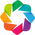

18 12
216
['comp_2' 'comp_2' 'comp_2' 'comp_3' 'comp_3' 'comp_2' 'comp_2' 'comp_2'
 'comp_2' 'comp_3' 'comp_3' 'comp_3' 'comp_2' 'comp_2' 'comp_2' 'comp_1'
 'comp_3' 'comp_2' 'comp_3' 'comp_1' 'comp_3' 'comp_2' 'comp_2' 'comp_1'
 'comp_1' 'comp_2' '-' '-' '-' '-' '-' '-' '-' 'comp_1' 'comp_3' 'comp_2'
 'comp_3' 'comp_2' 'comp_1' '-' '-' '-' '-' '-' '-' '-' 'comp_3' 'comp_3'
 'comp_3' 'comp_1' '-' '-' 'comp_3' 'comp_1' 'comp_1' 'comp_2' '-' '-'
 'comp_1' 'comp_3' 'comp_3' 'comp_3' '-' '-' 'comp_1' 'comp_1' 'comp_1'
 'comp_1' '-' 'comp_1' 'comp_1' 'comp_1' 'comp_1' 'comp_1' '-' 'comp_1'
 'comp_1' 'comp_1' 'comp_1' '-' '-' '-' 'comp_2' 'comp_1' 'comp_1' '-' '-'
 'comp_1' 'comp_2' 'comp_1' '-' '-' '-' 'comp_3' 'comp_1' 'comp_3'
 'comp_2' '-' '-' 'comp_3' 'comp_1' 'comp_2' '-' '-' 'comp_1' 'comp_2' '-'
 '-' '-' '-' '-' 'comp_3' 'comp_3' '-' '-' 'comp_2' 'comp_1' '-' '-' '-'
 '-' '-' 'comp_3' 'comp_2' '-' '-' '-' 'comp_1' 'comp_1' '-' '-' 'comp_3'
 'comp_2' 'comp_1' 'comp_2' '-' '-' '-' 'com

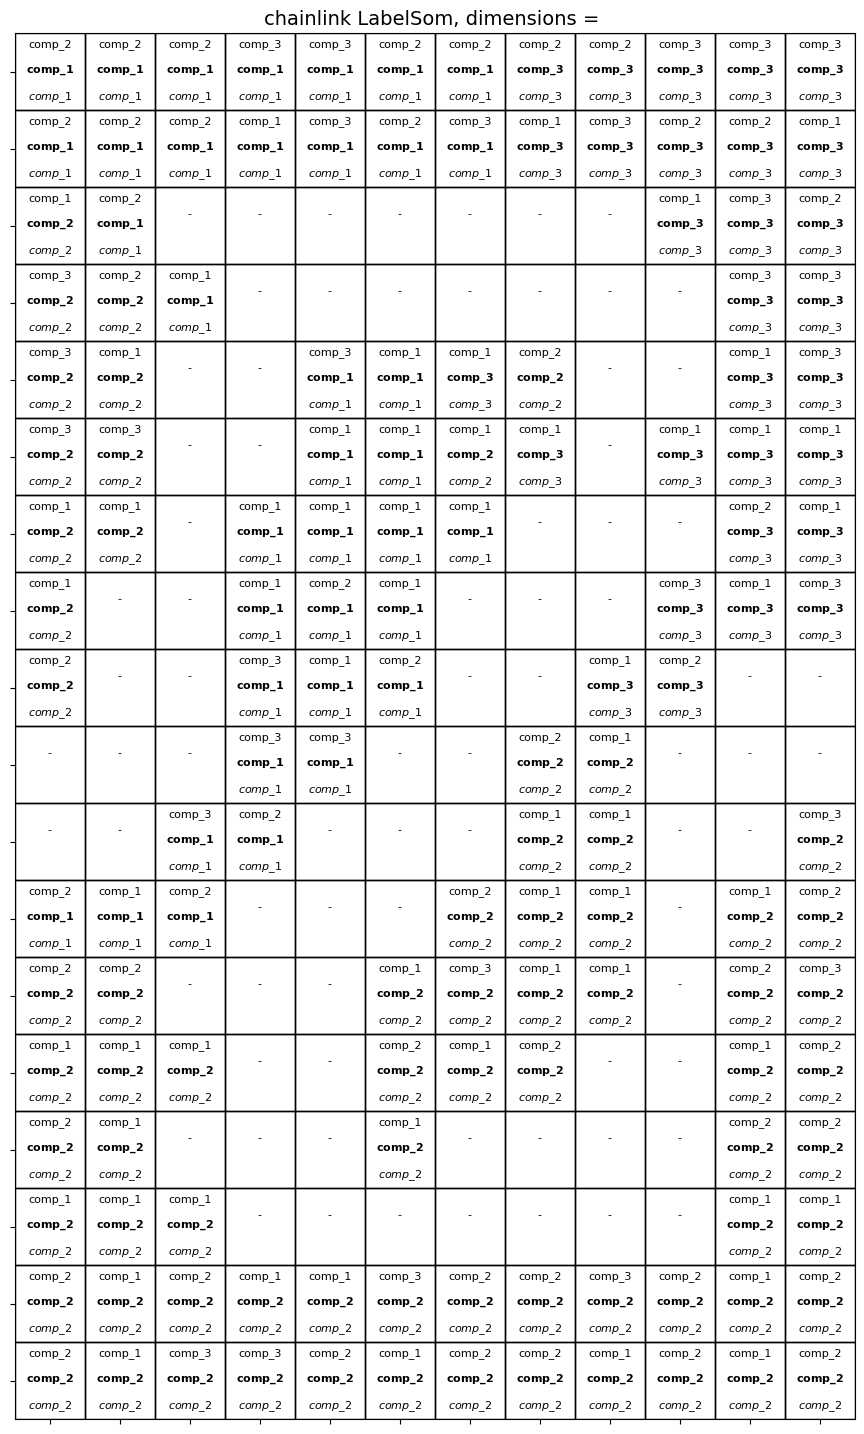

In [450]:
import panel as pn
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

ydim = weights['ydim']
xdim = weights['xdim']
print(ydim, xdim)
(a,b,c) = stringMatrices(ydim, xdim, weights['arr'], idata['arr'], printValues=False)

printSomLabels(a, [xdim, ydim], ["chainlink LabelSom", "dimensions = "], b, c, [14,18], 8, 1.1)

#hithist = hv.Image(HitHist(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'])).opts(xaxis=None, yaxis=None) 
#um = hv.Image(UMatrix(weights['ydim'], weights['ydim'], weights['arr'], 4)).opts(xaxis=None, yaxis=None) 
#sdh = hv.Image(SDH(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 25, 0)).opts(xaxis=None, yaxis=None)   

#hv.Layout([hithist.relabel('HitHist').opts(cmap='kr')])

In [ ]:
#train the 10x10 and 100x60 SOMs with MiniSom

from SOMToolBox_Parse import SOMToolBox_Parse
from minisom import MiniSom 
import math
idata = SOMToolBox_Parse("datasets\\10clusters\\10clusters.vec").read_weight_file()

#training the soms with the suitable parameters
#the suitable parameters were found by iterating multiple times over different values of sigma (neighborhood radius) and learning_rate,
#and training the Soms with them. Their respective quantization errors were then looked at and the parameters that resulted 
# in thebest (lowest) values were then chosen as their suitable parameters. The parameters and the resulting best value is printed,
# and the soms are trained on them and show their own quantization errors when newly trained
som_10_cluster_10_10 = MiniSom(10, 10, 10, sigma=1.0, learning_rate=0.7)
som_10_cluster_10_10.train(idata['arr'], 10000)
print('10_cluster, 10 10')
print('neighborhood radius: ', 2.5, ' learning rate: ', 3.8, ' best value',  0.0399)
print('QUANTERROR_UNIT_AVG: ', (som_10_cluster_10_10.quantization_error(idata['arr'])))
print()

som_10_cluster_100_60 = MiniSom(100, 60, 10, sigma=2.5, learning_rate=3.8)
som_10_cluster_100_60.train(idata['arr'], 10000)
print('10_cluster, 100 60')
print('neighborhood radius: ', 2.5, ' learning rate: ', 3.8, ' best value',  0.020)
print('QUANTERROR_UNIT_AVG: ', (som_10_cluster_100_60.quantization_error(idata['arr'])))
print()


idata = SOMToolBox_Parse("datasets\\chainlink\\chainlink.vec").read_weight_file()

som_chainlink_10_10 = MiniSom(10, 10, 3, sigma=1.0, learning_rate=0.4)
som_chainlink_10_10.train(idata['arr'], 10000)
print('chainlink, 10 10')
print('neighborhood radius: ', 1.0, ' learning rate: ', 0.4, ' best value',  0.0396)
print('QUANTERROR_UNIT_AVG: ', (som_chainlink_10_10.quantization_error(idata['arr'])))
print()

som_chainlink_100_60 = MiniSom(100, 60, 3, sigma=1.9, learning_rate=3.4)
som_chainlink_100_60.train(idata['arr'], 10000)
print('chainlink, 100 60') #, i = ', i, 'lr = ', 2.5+(i/10))
print('neighborhood radius: ', 1.9, ' learning rate: ', 3.4, ' best value',  0.0014)
print('QUANTERROR_UNIT_AVG: ', (som_chainlink_100_60.quantization_error(idata['arr'])))
print()